In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import koopomics as ko
import pandas as pd
import torch.nn as nn

In [2]:
# Load Dataset
pregnancy_df = pd.read_csv('/Users/daviddornig/Documents/Master_Thesis/Bioinf/Code/philipp-trinh/KOOPOMICS/input_data/pregnancy/pregnancy_interpolated_264M_robust_minmax_scaled_outlrem_uniform.csv')

condition_id = 'Condition'
time_id = 'Gestational age (GA)/weeks'
replicate_id = 'Subject ID'
feature_list = pregnancy_df.columns[7:]
num_features = len(feature_list)

train_set_df = pregnancy_df[pregnancy_df['Cohort'] == 'Discovery'].copy()
test_set_df = pregnancy_df[pregnancy_df['Cohort'] == 'Validation (Test Set 1)'].copy()
train_dataloader = ko.OmicsDataloader(train_set_df, feature_list, time_id=time_id, replicate_id=replicate_id, batch_size=30)
test_dataloader = ko.OmicsDataloader(test_set_df, feature_list, time_id=time_id,replicate_id=replicate_id, batch_size=30)


In [3]:
embedding_model = ko.FF_AE([264,2000,2000,100], [100,2000,2000,264],E_dropout_rates= [0,0,0,0],activation_fn='leaky_relu')
#operator_model = ko.LinearizingKoop(linearizer=ko.FFLinearizer([3,1000,10], [10,1000,3], linE_dropout_rates=[0,0,0]), koop=ko.InvKoop(latent_dim=10, reg='skewsym'))
operator_model = ko.InvKoop(latent_dim=100, reg='nondelay')

TestingKoop = ko.KoopmanModel(embedding=embedding_model, operator=operator_model)


Model loaded with:
FF_AE module
InvKoop module
An invertible Koop


In [5]:
# Load Model Parameters
param_path = '/Users/daviddornig/Documents/Master_Thesis/Bioinf/Code/philipp-trinh/KOOPOMICS/TestingKoop264M_tanh_nondelay.pth'
TestingKoop.load_state_dict(torch.load(param_path,  map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
import torch
input_tensor = torch.tensor(pregnancy_df[feature_list].values, dtype=torch.float32)

with torch.no_grad(): 
    latent_representations, identity_outputs = TestingKoop.embed(input_tensor)

In [7]:
mask = input_tensor != -2

In [8]:
identity_outputs[mask]

tensor([-0.0102, -0.3502,  0.3065,  ...,  0.3870,  0.0509,  0.4252])

In [9]:
criterion = ko.masked_criterion(nn.MSELoss(),mask_value=-2)
criterion(identity_outputs, input_tensor)

tensor(0.0292)

In [10]:
latent_representations.shape

torch.Size([1020, 100])

In [12]:
masked_latent = torch.where(mask[:, :100], latent_representations, torch.tensor(0.0, device=latent_representations.device))
masked_latent

tensor([[ 0.1245,  0.1196,  0.0611,  ...,  0.0065,  0.0207,  0.0516],
        [ 0.0853,  0.0874,  0.1070,  ...,  0.0164,  0.0310,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0074, -0.0175, -0.0394,  ...,  0.0318,  0.0471,  0.0440],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

Explained variance by each component: [0.18264537 0.16033706 0.08434819]


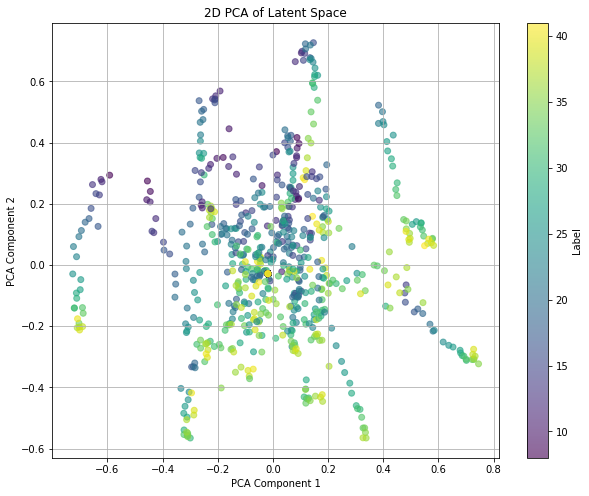

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert the latent representations to a NumPy array
latent_representations_np = masked_latent.numpy()  # Shape: (num_samples, latent_dim)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=3)
latent_2d = pca.fit_transform(latent_representations_np)
explained_variance = pca.explained_variance_ratio_
print("Explained variance by each component:", explained_variance)


# Assuming you have some labels for coloring the points (e.g., from the DataFrame)
# Here, we're assuming the label is in the first column of the DataFrame
labels = pregnancy_df[time_id].values  # Adjust based on your DataFrame structure

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
#np.zeros_like(latent_2d)
# Create a color bar
plt.colorbar(scatter, label='Label')
plt.title('2D PCA of Latent Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

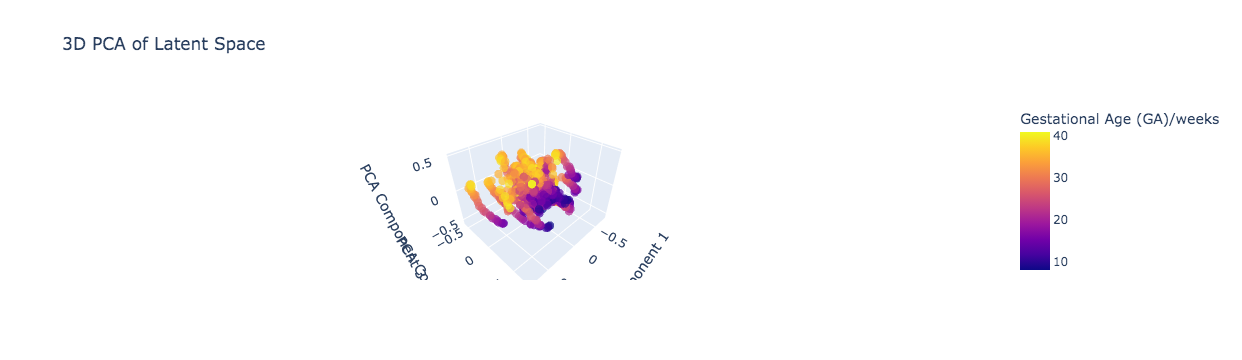

In [18]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

# Assuming latent_representations is your tensor
latent_representations_np = masked_latent.numpy()  # Convert to NumPy array

# Apply PCA to reduce to 3 dimensions if not already done
pca = PCA(n_components=3)
latent_3d = pca.fit_transform(latent_representations_np)

# Assuming you have some labels for coloring the points (e.g., from the DataFrame)
time = pregnancy_df[time_id].values   # Adjust this based on your DataFrame structure
replicate = pregnancy_df[replicate_id].values

# Create a DataFrame for Plotly
pca_df = pd.DataFrame(latent_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df['time'] = time
pca_df['replicate'] = replicate


# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='time',
    title='3D PCA of Latent Space',
    labels={'time': 'Gestational Age (GA)/weeks', 'replicate': 'Subject ID'},  # Adjust based on your label
    opacity=0.7,
    hover_data = {'replicate':True}
)

# Update the layout
fig.update_traces(marker=dict(size=5))
fig.update_layout(
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3',
    )
)

# Show the plot
fig.show()


In [ ]:
train_delay_dataloader = ko.dataloader(train_set_df, feature_list, condition_id=condition_id, time_id=time_id, replicate_id=replicate_id, batch_size=50, delay_length_input=3, delay_modification='flatten')
test_delay_dataloader = ko.dataloader(test_set_df, feature_list, condition_id=condition_id, time_id=time_id, replicate_id=replicate_id, batch_size=50, delay_length_input=3, delay_modification='flatten')


In [ ]:
for batch in train_delay_dataloader:
    print(batch['input_data'][0].shape)

    break

In [ ]:
#embedding_model = ko.Conv_AE(num_features, E_num_conv=4, D_num_conv=2, E_dropout_rates=[0,0,0,0], kernel_size=3)
embedding_model = ko.FF_AE([150,300,250,100,150,100,50], [50,100,150,200,250,300,150])
#embedding_model = ko.Conv_E_FF_D(num_features, E_num_conv=4, D_layer_dims=[1,100,100,3],  E_dropout_rates=[0,0,0,0], kernel_size=3)


operator_model = ko.LinearizingKoop(linearizer=ko.FFLinearizer([50,100,80,60,40,30,10], [10,30,40,60,80,100,50]), koop=ko.InvKoop(latent_dim=10, reg='skewsym'))
#operator_model = ko.InvKoop(latent_dim=50, reg='skewsym')
TestingKoopdelayAE = ko.KoopmanModel(embedding=embedding_model, operator=operator_model)
TestingKoopdelayAE

In [ ]:
ko.train_embedding(TestingKoopdelayAE, train_delay_dataloader, test_delay_dataloader, 
                lr=0.001, num_epochs=200, print_batch_info=False, model_name='TestingKoopdelayAE')

In [ ]:
# Load Model Parameters
param_path = '/Users/daviddornig/Documents/Master_Thesis/Bioinf/Code/philipp-trinh/KOOPOMICS/Developing/TestingKoopConv_embedding_trained.pth'
TestingKoopConv.embedding.load_state_dict(torch.load(param_path))

In [ ]:
test_input_data = torch.tensor(pregnancy_df.iloc[7:10][feature_list].values.astype(np.float32).T)

In [ ]:
ko.test_embedding(TestingKoop, test_delay_dataloader)

In [ ]:
pregnancy_df.iloc[7:10]

In [ ]:
print(test_input_data.flatten())

In [ ]:
latent, identity = TestingKoop.embed(test_input_data.flatten())

In [ ]:
identity

In [ ]:


criterion = nn.MSELoss()
criterion(identity, test_input_data.flatten())

In [ ]:
latent_representations, time_label = ko.predict_dataloader(TestingKoop, train_dataloader)

In [ ]:
latent_representations = latent_representations.squeeze()

In [ ]:
latent_representations.shape

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert the latent representations to a NumPy array
latent_representations_np = latent_representations.numpy()  # Shape: (num_samples, latent_dim)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=3)
latent_2d = pca.fit_transform(latent_representations_np)
explained_variance = pca.explained_variance_ratio_
print("Explained variance by each component:", explained_variance)


# Assuming you have some labels for coloring the points (e.g., from the DataFrame)
# Here, we're assuming the label is in the first column of the DataFrame
labels = time_label  # Adjust based on your DataFrame structure

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
#np.zeros_like(latent_2d)

# Create a color bar
plt.colorbar(scatter, label='Label')
plt.title('2D PCA of Latent Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

# Assuming latent_representations is your tensor
latent_representations_np = latent_representations.numpy()  # Convert to NumPy array

# Apply PCA to reduce to 3 dimensions if not already done
pca = PCA(n_components=3)
latent_3d = pca.fit_transform(latent_representations_np)

# Assuming you have some labels for coloring the points (e.g., from the DataFrame)
labels = time_label  # Adjust this based on your DataFrame structure

# Create a DataFrame for Plotly
pca_df = pd.DataFrame(latent_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df['Label'] = labels

# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Label',
    title='3D PCA of Latent Space',
    labels={'Label': 'Gestational Age (GA)/weeks'},  # Adjust based on your label
    opacity=0.7
)

# Update the layout
fig.update_traces(marker=dict(size=5))
fig.update_layout(
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3',
    )
)

# Show the plot
fig.show()


In [ ]:
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
pregnancy_df = pd.read_csv('/Users/daviddornig/Documents/Master_Thesis/Bioinf/Code/philipp-trinh/KOOPOMICS/input_data/pregnancy/pregnancy_interpolated_featselected50M_robustscaled.csv')

# Define column names
condition_id = 'Condition'
time_id = 'Gestational age (GA)/weeks'
replicate_id = 'Subject ID'
feature_list = pregnancy_df.columns[7:]  # Feature columns to use for UMAP

# Prepare the feature matrix for UMAP
X = pregnancy_df[feature_list].values  # Select only the feature columns

# Initialize and fit UMAP
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.01, n_components=2, random_state=42)
umap_result = umap_model.fit_transform(X)

# Create a DataFrame for UMAP results with the labels
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'])
umap_df[condition_id] = pregnancy_df[condition_id].values
umap_df[time_id] = pregnancy_df[time_id].values
umap_df[replicate_id] = pregnancy_df[replicate_id].values

# Plot the UMAP results labeled by `condition_id`
plt.figure(figsize=(12, 8))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue=condition_id, palette='viridis', alpha=0.7)
plt.title('UMAP Projection of Pregnancy Data Labeled by Condition')
plt.legend(loc='best')
plt.show()

# Plot the UMAP results labeled by `time_id`
plt.figure(figsize=(12, 8))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue=time_id, palette='coolwarm', alpha=0.7)
plt.title('UMAP Projection of Pregnancy Data Labeled by Gestational Age')
plt.legend(loc='best')
plt.show()

# Plot the UMAP results labeled by `replicate_id`
plt.figure(figsize=(12, 8))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue=replicate_id, palette='tab10', alpha=0.7)
plt.title('UMAP Projection of Pregnancy Data Labeled by Subject ID')
plt.legend(loc='best')
plt.show()



In [ ]:
import pandas as pd
import umap.umap_ as umap
import plotly.express as px

# Load your data
pregnancy_df = pd.read_csv('/Users/daviddornig/Documents/Master_Thesis/Bioinf/Code/philipp-trinh/KOOPOMICS/input_data/pregnancy/pregnancy_interpolated_featselected50M_robustscaled.csv')

# Define identifiers and feature list
condition_id = 'Condition'
time_id = 'Gestational age (GA)/weeks'
replicate_id = 'Subject ID'
feature_list = pregnancy_df.columns[7:]  # Feature columns to use for UMAP

# Prepare the feature matrix for UMAP
X = pregnancy_df[feature_list].values  # Select only the feature columns

# Initialize and fit UMAP
umap_model = umap.UMAP(n_neighbors=6, min_dist=0.1, n_components=2, random_state=42)
umap_result = umap_model.fit_transform(X)

# Create a DataFrame for UMAP results with the labels
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'])
umap_df[condition_id] = pregnancy_df[condition_id].values
umap_df[time_id] = pregnancy_df[time_id].values
umap_df[replicate_id] = pregnancy_df[replicate_id].values

# Plot with Plotly
fig = px.scatter(
    umap_df, 
    x='UMAP1', 
    y='UMAP2', 
    color=time_id,
    hover_data={condition_id: True, replicate_id: True, time_id: True},
    labels={time_id: 'Gestational Age (GA)/weeks'},
    title='UMAP Projection of Pregnancy Data',
)

# Customize the plot layout
fig.update_traces(marker=dict(size=7, opacity=0.7))
fig.update_layout(
    title='UMAP Projection of Pregnancy Data Colored by Gestational Age',
    xaxis_title='UMAP Dimension 1',
    yaxis_title='UMAP Dimension 2',
)

# Display the plot
fig.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import plotly.express as px
import umap

# Load and prepare the data
pregnancy_df = pd.read_csv('/Users/daviddornig/Documents/Master_Thesis/Bioinf/Code/philipp-trinh/KOOPOMICS/input_data/pregnancy/pregnancy_interpolated_featselected50M_robustscaled.csv')
feature_list = pregnancy_df.columns[7:]
X = pregnancy_df[feature_list].values

# Initialize and fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
pregnancy_df['is_outlier'] = iso_forest.fit_predict(X)  # -1 for outliers, 1 for inliers
pregnancy_df['anomaly_score'] = iso_forest.decision_function(X)

# Optional: Reduce data to 2D with UMAP for visualization
umap_model = umap.UMAP(n_neighbors=6, min_dist=0.1, n_components=2, random_state=42)
umap_result = umap_model.fit_transform(X)

# Add UMAP results to DataFrame
pregnancy_df['umap_x'] = umap_result[:, 0]
pregnancy_df['umap_y'] = umap_result[:, 1]

# Plot with Plotly, coloring by anomaly score
fig = px.scatter(pregnancy_df, x='umap_x', y='umap_y', color='is_outlier', 
                 hover_data=['Condition', 'Gestational age (GA)/weeks', 'Subject ID'],
                 title='Isolation Forest Outlier Detection with UMAP Reduction')
fig.update_layout(coloraxis_colorbar=dict(title="Outlier Status"))
fig.show()


In [ ]:
pregnancy_df['Subject ID'].unique()

# Hankel Matrix

In [ ]:
import pandas as pd
import numpy as np
from scipy.linalg import hankel

# Step 1: Load the data
pregnancy_df = pd.read_csv('/Users/daviddornig/Documents/Master_Thesis/Bioinf/Code/philipp-trinh/KOOPOMICS/input_data/pregnancy/pregnancy_interpolated_featselected50M_robustscaled_outlrem.csv')

# Step 2: Filter the DataFrame
condition_id = 'Condition'
time_id = 'Gestational age (GA)/weeks'
replicate_id = 'Subject ID'
feature_list = pregnancy_df.columns[7:]  # Assuming features start from the 8th column
num_features = len(feature_list)

# Select the training set
train_set_df = pregnancy_df[pregnancy_df['Cohort'] == 'Discovery'].copy()

# Step 3: Create Hankel matrices and perform SVD
# Set the delay length (number of time steps)
delay_length = 3  # You can adjust this as needed

hankel_matrices = []
hankel_shapes = []
for sample in pregnancy_df['Subject ID'].unique():
    for feature in feature_list:
        # Extract time series data for the specific feature
        feature_data = train_set_df[train_set_df[replicate_id] == sample][feature].values  # Shape: (n_timepoints,)
        
        # Create a Hankel matrix
        if len(feature_data) >= 2 * delay_length - 1:
            # Create a Hankel matrix
            hankel_matrix = hankel(feature_data[:delay_length], feature_data[delay_length - 1:])
            hankel_matrices.append(hankel_matrix)
            hankel_shapes.append(hankel_matrix.shape)

            
max_rows = max(shape[0] for shape in hankel_shapes)
max_cols = max(shape[1] for shape in hankel_shapes)

padded_hankel_matrices = []
for matrix in hankel_matrices:
    padded_matrix = np.pad(matrix, 
                           ((0, max_rows - matrix.shape[0]), 
                            (0, max_cols - matrix.shape[1])),
                           mode='constant', constant_values=0)
    padded_hankel_matrices.append(padded_matrix)

# Convert to a 3D NumPy array if needed
padded_hankel_array = np.array(padded_hankel_matrices)  # Shape: (num_matrices, max_rows, max_cols)

# Step 5: Reshape for SVD
hankel_concatenated = padded_hankel_array.reshape(padded_hankel_array.shape[0]*padded_hankel_array.shape[2], padded_hankel_array.shape[1])  # Flatten to shape (num_features*delay_length, delay_length)

# Step 6: Perform SVD
U, S, Vt = np.linalg.svd(hankel_concatenated)

# Output the results
print("U shape:", U.shape)
print("Singular values (S):", S)
print("Vt shape:", Vt.shape)

# Optional: Print the first few singular values
print("First few singular values:", S[:5])
